In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The BrainLat dataset contains neuroimaging and cognitive data from 780 subjects, including patients with AD (N =278), bvFTD (N =163), PD (N =57) and MS (N =32), and HCs (N =250).

Alzheimer's disease (AD), behavioral variant frontotemporal dementia (bvFTD), multiple sclerosis (MS), Parkinson's disease (PD), and healthy controls (HCs).

Using the MNE library to visualize and process .set data [MNE](https://mne.tools/stable/index.html)

In [ ]:
!pip install mne   #procesa señales eeg
!pip install spkit #Hace Wavelets
!pip install pywt
import mne
import numpy as np
from scipy.signal import stft
import os
import cv2
import pandas as pd
import spkit as sp
from spkit.cwt import ScalogramCWT
from spkit.cwt import compare_cwt_example
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 49.3 MB/s eta 0:00:00
  Created wheel for python-picard: filename=python_picard-0.8-py3-none-any.whl size=16394 sha256=3069ad2837ab26ae94926e2f450364b372e3ff531d55957c5eb9b504553feebe
  Stored in directory: /root/.cache/pip/wheels/86/7e/fc/6183c6bfdc791d9e7b5a1df84ec4f30055f76bc8414ab2300d
Successfully built python-picard
ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<fro

<ipython-input-5-73a98f9576a9>:4: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw = mne.io.read_raw_eeglab("/content/drive/MyDrive/BrainLat/EEG data/1_AD/AR/sub-30015/eeg/s6_sub-30015_rs-HEP_eeg.set")


Using matplotlib as 2D backend.


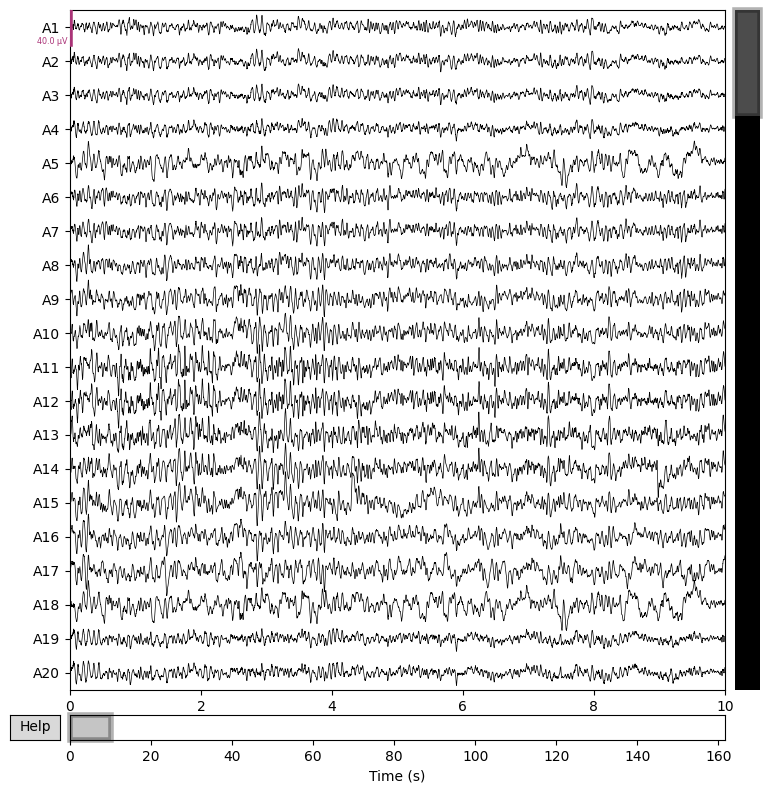

In [ ]:
# Load the .set file
raw = mne.io.read_raw_eeglab("/content/drive/MyDrive/BrainLat/EEG data/1_AD/AR/sub-30015/eeg/s6_sub-30015_rs-HEP_eeg.set")
# Visualize the data
raw.plot()
# Extract data
# Get data from all channels
data = raw.get_data(picks=raw.ch_names)
# Get data from raw object
data = raw.get_data()
# Get time points
times = raw.times
# Get sampling frequency
fs = raw.info['sfreq']

## ESPECTOGRAMAS

In [ ]:
# @title STFT
import os
import numpy as np
import mne
from scipy.signal import stft
import cv2

# Base directories for data and saving
base_data_path = '/content/drive/MyDrive/BrainLat/EEG data'
base_save_path = '/content/drive/MyDrive/BrainLat/Vectores/sfft'
os.makedirs(base_save_path, exist_ok=True)

# Folders of interest containing different classes of data
folders_of_interest = ['5_HC', '2_bvFTD', '1_AD']
conditions_of_interest = ['CL', 'AR']

# Function to resize the STFT image using OpenCV
def resize_stft_with_opencv(stft_result, target_shape=(224, 224)):
    resized_stft = cv2.resize(stft_result, target_shape, interpolation=cv2.INTER_CUBIC)
    return resized_stft

# Loop through each folder of interest
for folder in folders_of_interest:
    for condition in conditions_of_interest:
        current_folder_path = os.path.join(base_data_path, folder, condition)

        # Skip if the current folder path does not exist
        if not os.path.exists(current_folder_path):
            continue

        # Get the list of sub-folders
        sub_folders = next(os.walk(current_folder_path))[1]

        # Loop through each sub-folder
        for sub_folder in sub_folders:
            eeg_folder_path = os.path.join(current_folder_path, sub_folder, 'eeg')

            # Skip if the eeg folder path does not exist
            if not os.path.exists(eeg_folder_path):
                continue

            # Loop through each file in the eeg folder
            for file in os.listdir(eeg_folder_path):
                # Process only .set files
                if file.endswith('.set'):
                    set_file_path = os.path.join(eeg_folder_path, file)

                    try:
                        # Read the raw EEG data using MNE
                        raw = mne.io.read_raw_eeglab(set_file_path, preload=True)
                        data = raw.get_data()
                        fs = raw.info['sfreq']

                        # Process STFT and FFT
                        stft_resized_list = []
                        for i in range(data.shape[0]):  # Iterate over channels
                            # Compute the STFT
                            f, _, Zxx = stft(data[i], fs, nperseg=4*fs, noverlap=3*fs, nfft=int(5.6*fs))
                            freq_index = np.where(f <= 40)[0][-1]  # Find the index where frequency is approximately 40Hz
                            s = np.abs(Zxx)[:freq_index+1, :]
                            s = resize_stft_with_opencv(np.flipud(s))  # Resize and flip the STFT result
                            stft_resized_list.append(s)

                        # Transpose and save the STFT result
                        stft_result = np.transpose(np.array(stft_resized_list), (1, 2, 0))

                        # Save the result as a .npy file
                        save_name = f"{sub_folder}.npy"
                        save_path = os.path.join(base_save_path, folder, save_name)
                        os.makedirs(os.path.dirname(save_path), exist_ok=True)
                        np.save(save_path, stft_result)

                        print(f"Saved: {save_path}")
                    except Exception as e:
                        print(f"Error processing file: {set_file_path}")
                        print(e)

In [ ]:
# @title Wavelet con spkit

# Base directories for data and saving
base_data_path = '/content/drive/MyDrive/BrainLat/EEG data'
base_save_path = '/content/drive/MyDrive/BrainLat/Vectores/cmex'
os.makedirs(base_save_path, exist_ok=True)

# Folders of interest containing different classes of data
folders_of_interest = ['5_HC', '2_bvFTD', '1_AD']
conditions_of_interest = ['CL', 'AR']

# Function to resize the wavelet image using OpenCV
def resize_wavelet_with_opencv(wavelet_result, target_shape=(224, 224)):
    resized_wavelet = cv2.resize(wavelet_result, target_shape, interpolation=cv2.INTER_CUBIC)
    return resized_wavelet

# Function to calculate and save the wavelet transform
def calculate_and_save_wavelet(eeg_data, fs, participant_id, wavelet_type, times,folder):
    wavelet_channels = []

    # Define frequency parameters for the wavelet transform
    f = np.linspace(0.5, 40, 224)  # Frequency range for the wavelet

    for i in range(eeg_data.shape[0]):  # Iterate over channels
        # Compute the Scalogram using ScalogramCWT from spkit
        if wavelet_type == 'cMaxican':
            XW, _ = ScalogramCWT(eeg_data[i], times, fs=fs, wType=wavelet_type, f0=f, a=0.01)
        else:
            raise ValueError("Wavelet type not supported")

        # Get the magnitude of the scalogram and resize to 224x224
        wavelet_magnitude = np.flipud(np.abs(XW))
        wavelet_resized = resize_wavelet_with_opencv(wavelet_magnitude)
        wavelet_channels.append(wavelet_resized)

    # Stack the wavelet results into a 3D tensor (224x224x128)
    wavelet_3d = np.stack(wavelet_channels, axis=-1)

    # Save the result as a .npy file
    output_path = os.path.join(base_save_path,folder,f"{participant_id}.npy")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    np.save(output_path, wavelet_3d)

    return output_path

# Loop through each folder of interest
for folder in folders_of_interest:
    for condition in conditions_of_interest:
        current_folder_path = os.path.join(base_data_path, folder, condition)

        # Skip if the current folder path does not exist
        if not os.path.exists(current_folder_path):
            continue

        # Get the list of sub-folders
        sub_folders = next(os.walk(current_folder_path))[1]

        # Loop through each sub-folder
        for sub_folder in sub_folders:
            eeg_folder_path = os.path.join(current_folder_path, sub_folder, 'eeg')

            # Skip if the eeg folder path does not exist
            if not os.path.exists(eeg_folder_path):
                continue

            # Loop through each file in the eeg folder
            for file in os.listdir(eeg_folder_path):
                # Process only .set files
                if file.endswith('.set'):
                    set_file_path = os.path.join(eeg_folder_path, file)

                    try:
                        # Read the raw EEG data using MNE
                        raw = mne.io.read_raw_eeglab(set_file_path, preload=True)
                        data = raw.get_data()
                        fs = raw.info['sfreq']
                        times = raw.times

                        # Calculate and save the wavelet transform
                        wavelet_type = 'cMaxican'  # You can change this to other wavelet types if needed
                        output_path = calculate_and_save_wavelet(data, fs, sub_folder, wavelet_type, times,folder)

                        print(f"Saved: {output_path}")
                    except Exception as e:
                        print(f"Error processing file: {set_file_path}")
                        print(e)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWar

Reading /content/drive/MyDrive/BrainLat/EEG data/5_HC/CL/sub-10008/eeg/s6_sub-10008_rs_eeg.fdt


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<fro

Reading 0 ... 306326  =      0.000 ...   598.293 secs...


/usr/local/lib/python3.11/dist-packages/spkit/cwt/cwt_fn.py:768: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.11/dist-packages/spkit/cwt/cwt_fn.py:768: RuntimeWarning: overflow encountered in multiply


Saved: /content/drive/MyDrive/BrainLat/Vectores/cmex/5_HC/sub-10008.npy
Reading /content/drive/MyDrive/BrainLat/EEG data/5_HC/CL/sub-10005/eeg/s6_sub-10005_rs_eeg.fdt
Reading 0 ... 297654  =      0.000 ...   581.355 secs...
Saved: /content/drive/MyDrive/BrainLat/Vectores/cmex/5_HC/sub-10005.npy
Reading /content/drive/MyDrive/BrainLat/EEG data/5_HC/CL/sub-100046/eeg/s6_sub-100046_rs_eeg.fdt
Error processing file: /content/drive/MyDrive/BrainLat/EEG data/5_HC/CL/sub-100046/eeg/s6_sub-100046_rs_eeg.set
File /content/drive/MyDrive/BrainLat/EEG data/5_HC/CL/sub-100046/eeg/s6_sub-100046_rs_eeg.fdt not found.
Reading /content/drive/MyDrive/BrainLat/EEG data/5_HC/CL/sub-100045/eeg/s6_sub-100045_rs_eeg.fdt
Error processing file: /content/drive/MyDrive/BrainLat/EEG data/5_HC/CL/sub-100045/eeg/s6_sub-100045_rs_eeg.set
File /content/drive/MyDrive/BrainLat/EEG data/5_HC/CL/sub-100045/eeg/s6_sub-100045_rs_eeg.fdt not found.
Reading /content/drive/MyDrive/BrainLat/EEG data/5_HC/CL/sub-100044/eeg/s6_s

In [ ]:
ad=np.load('/content/drive/MyDrive/BrainLat/Vectores/sfft/1_AD/sub-30014.npy')

In [ ]:
ad.shape

(224, 224, 128)

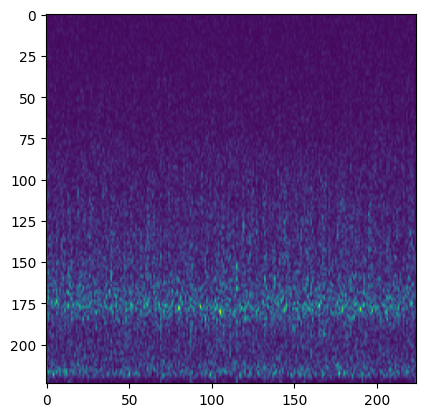

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(ad[:,:,0])